# Эвристический алгоритм детекции аномалий

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings; warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score 

In [2]:
train = pd.read_csv('/content/drive/MyDrive/CardioSpike/data/train.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60487 entries, 0 to 60486
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      60487 non-null  int64
 1   time    60487 non-null  int64
 2   x       60487 non-null  int64
 3   y       60487 non-null  int64
dtypes: int64(4)
memory usage: 1.8 MB


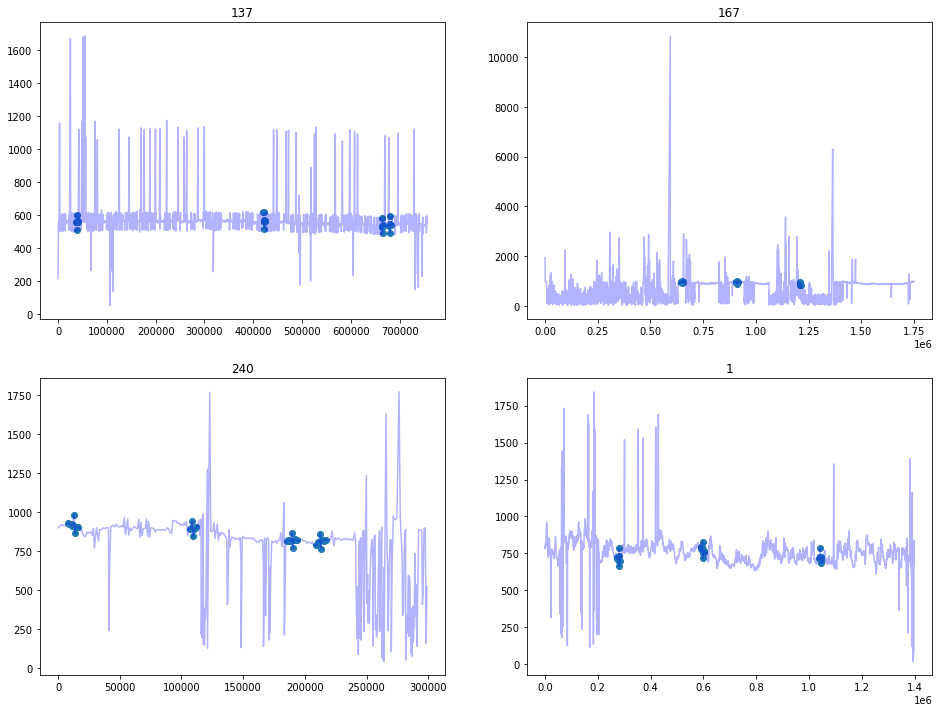

In [4]:
plt.figure(figsize=(16, 12))
i = 0
for id in train[train['y'] == 0].sample(4)['id'].unique():
    size = np.ceil(len(train[train['y'] == 1].sample(4)['id'].unique()) ** .5)
    plt.subplot(size, size, i + 1)
    i += 1
    id_data = train[train['id'] == id]
    plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o')
    plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
    plt.title(f'{id}')
plt.show()

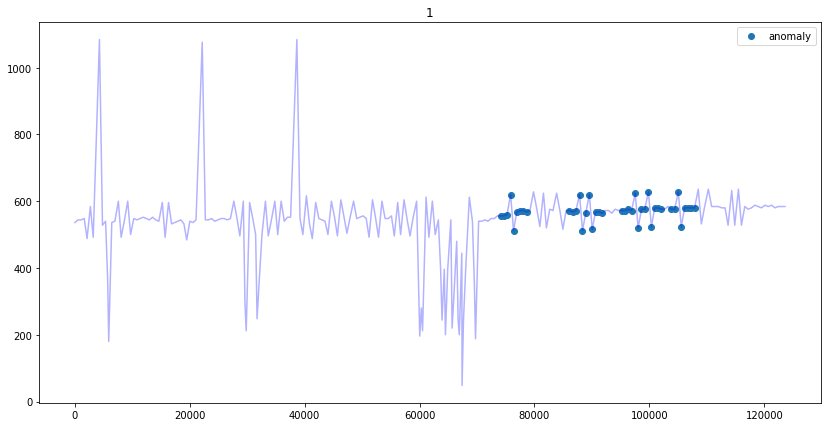

In [5]:
plt.figure(figsize=(14, 7))
id_data = train[train['id'] == 138]
plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o', label='anomaly')
plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
plt.legend()
plt.title(f'{id}')
plt.savefig('one_example.jpg')

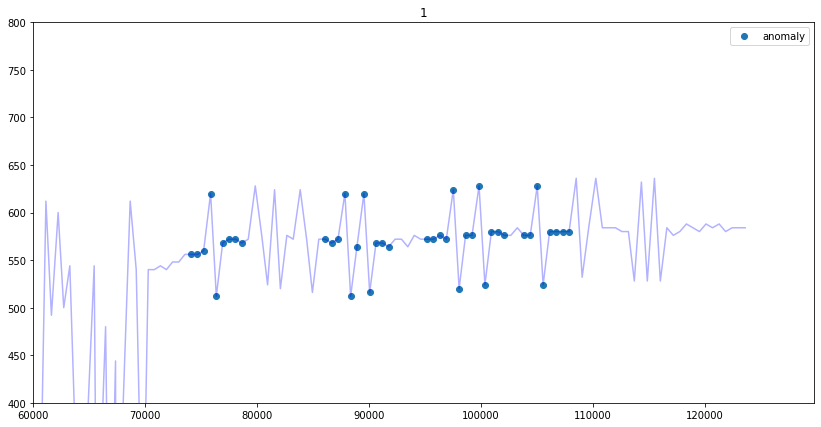

In [6]:
plt.figure(figsize=(14, 7))
id_data = train[train['id'] == 138]
plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o', label='anomaly')
plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3)
plt.legend()
plt.xlim(60000)
plt.ylim(400, 800)
plt.title(f'{id}')
plt.savefig('one_example.jpg')

Видно, что аномалии выглядят как идеальные "синусоиды", что будет если попробовать их описать "руками".

# No ML

In [7]:
def no_ml_predicter(df, min_rise=20, max_rise=70, first_plateau=25, second_plateau=25, height=25):
    if 'y' in df.columns:
        col_name = 'y_'
    else:
        col_name = 'y'
    df[col_name] = 0
    for x in range(len(df)-5):
        if df['x'].iloc[x] < 500:
            continue
        # сначало должно быть плато
        if abs(df['x'].iloc[x+1] - df['x'].iloc[x]) <= first_plateau:  
            first_rise = df['x'].iloc[x+2] - df['x'].iloc[x+1]
            # потом подъем
            if min_rise <= first_rise <= max_rise:
                # потом спуск который уходит ниже первого плато
                if df['x'].iloc[x+3] < (df['x'].iloc[x+1] - (0.5 * first_rise)):
                    # а потом опять плато
                    if abs(df['x'].iloc[x+4] - df['x'].iloc[x]) <= second_plateau:
                        # при этом нужно чтобы между первым плато и втором расстояние было не очень большим
                        if abs(df['x'].iloc[x+4] - df['x'].iloc[x+5]) <= height:
                            df.iloc[x:x+6, df.columns.get_loc(col_name)] = 1
    
    return df

In [8]:
test = pd.read_csv('/content/drive/MyDrive/CardioSpike/data/test.csv')

In [9]:
test = no_ml_predicter(test)

In [10]:
test[['id', 'time', 'y']].to_csv('naz_sub12.csv', index=False)

In [11]:
%%time
no_ml_predicter(train)

CPU times: user 2.77 s, sys: 15.7 ms, total: 2.78 s
Wall time: 2.77 s


,id,time,x,y,y_
0,1,0,800,0,0
1,1,780,780,0,0
2,1,1572,792,0,0
3,1,2392,820,0,0
4,1,3196,804,0,0
...,...,...,...,...,...
60482,275,115360,552,0,1
60483,275,115912,552,0,1
60484,275,116464,552,0,0
60485,275,117020,556,0,0


In [12]:
id_136 = train[train['id'] == 136]

In [13]:
fig = px.line(id_136, x='time', y='x', color='y')
fig.show()

In [14]:
fig = px.line(id_136, x='time', y='x', color='y_')
fig.show()

In [15]:
train = no_ml_predicter(train)
f1_score(train['y_'], train['y'])

0.6920626665799909

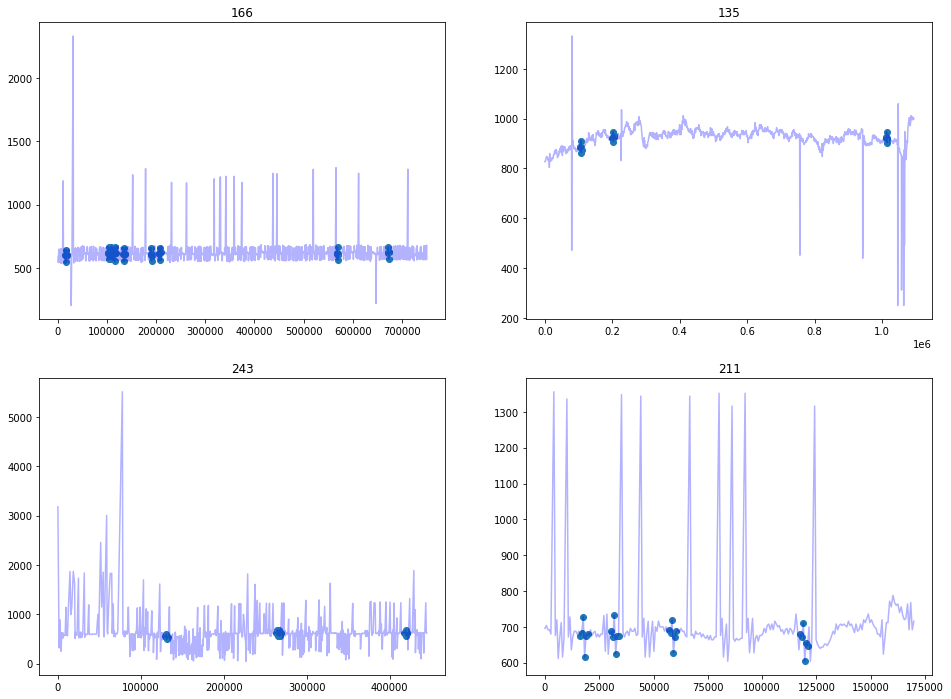

In [16]:
plt.figure(figsize=(16, 12))
i = 0
for id in test[test['y'] == 0].sample(4)['id'].unique():
    size = np.ceil(len(test[test['y'] == 1].sample(4)['id'].unique()) ** .5)
    plt.subplot(size, size, i + 1)
    i += 1
    id_data = test[test['id'] == id]
    plt.plot(id_data['time'][id_data['y'] == 1], id_data['x'][id_data['y'] == 1], 'o')
    plt.plot(id_data['time'], id_data['x'], 'blue', alpha=0.3);
    plt.title(f'{id}')
plt.show()